In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
import numpy as np
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
def swap_zeros_ones(arr):
    arr[arr == 0] = 2
    arr[arr == 1] = 0
    arr[arr == 2] = 1
    return arr

In [3]:
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [4]:
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

In [5]:
def ConvBlock(x, filters, kernel_size, strides, activation=mish):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(0.2)(x)
    return x

In [6]:
def ResidualBlock(x, filters, kernel_size, strides):
    res = x
    x = ConvBlock(x, filters, kernel_size, strides)
    x = ConvBlock(x, filters, kernel_size, 1)
    res = layers.Conv2D(filters, 1, strides=strides, padding='same')(res)
    res = layers.BatchNormalization()(res)
    x = layers.Add()([x, res])
    x = layers.Activation(mish)(x)
    return x

In [7]:
def PyramidPoolingModule(x, pool_sizes):
    concat_layers = [x]
    h, w = x.shape[1], x.shape[2]
    
    for pool_size in pool_sizes:
        y = AttentionBlock(x)
        y = layers.AveragePooling2D(pool_size=pool_size, strides=pool_size, padding='same')(y)
        y = ResidualBlock(y, 512*8 // len(pool_sizes), 1, 1)
        y = ConvBlock(y, 1024 // len(pool_sizes), 1, 1)
        y = tf.image.resize(y, (h, w), method=tf.image.ResizeMethod.BILINEAR)
        y = AttentionBlock(y)
        concat_layers.append(y)
    
    return layers.Concatenate()(concat_layers)

In [8]:
def AttentionBlock(x):
    attention = layers.Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer='he_normal', padding='same')(x)
    attention = layers.BatchNormalization()(attention)
    attention = layers.multiply([x, attention])
    return attention

In [9]:
def PSPNet(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    #x = PyramidPoolingModule(inputs, pool_sizes=[1, 2, 3, 4, 6, 8])
    
    x = ConvBlock(inputs, 64, 3, 2)
    x = ConvBlock(x, 64, 3, 1)
    
    x = AttentionBlock(x)

#     skip1 = x
    x = ResidualBlock(x, 128, 3, 2)
    
    x = ConvBlock(x, 128, 3, 1)
    
    x = AttentionBlock(x)

#     skip2 = x
    x = ResidualBlock(x, 256, 3, 2)
    x = ConvBlock(x, 256, 3, 1)
    
    x = AttentionBlock(x)

#     skip3 = x
    x = ResidualBlock(x, 512, 3, 2)

    x = ConvBlock(x, 512, 3, 1)
    
    x = AttentionBlock(x)

    ###
    ###
#     skip4 = x

    # Pyramid Pooling Module
    x = PyramidPoolingModule(x, pool_sizes=[1, 2, 3, 4, 6, 8, 10, 15])

    # Decoder
    ###
    ###
    #x = ConvBlock(x, 512, 3, 1)
    x = AttentionBlock(x)
    x = ConvBlock(x, 512, 3, 1)
    x = AttentionBlock(x)

#     x = layers.concatenate([skip4, x])
    x = ConvBlock(x, 256, 3, 1)
    x = AttentionBlock(x)

    #x = ConvBlock(x, 512, 3, 1)
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same')(x)
    
    x = ConvBlock(x, 128, 3, 1)
    x = AttentionBlock(x)

#     x = layers.concatenate([skip3, x])
    x = ConvBlock(x, 64, 3, 1)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)

    x = ConvBlock(x, 64, 3, 1)
    x = AttentionBlock(x)

#     x = layers.concatenate([skip2, x])
    x = ConvBlock(x, 32, 3, 1)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)

    x = ConvBlock(x, 32, 3, 1)
#     x = layers.concatenate([skip1, x])
    x = ConvBlock(x, 32, 3, 1)
    x = AttentionBlock(x)

    x = layers.Conv2DTranspose(16, 3, strides=2, padding='same')(x)
    
    x = ConvBlock(x, 16, 3, 1)
    x = AttentionBlock(x)

    x = ConvBlock(x, 8, 3, 1)
    x = AttentionBlock(x)

    # Output
    #x = ConvBlock(x, 1, 3, 1)
    
    #x = PyramidPoolingModule(x, pool_sizes=[1, 2, 3, 4, 6, 8, 10, 15])
    
    output = layers.Conv2D(1, 1, activation='sigmoid')(x)
    
    return Model(inputs=inputs, outputs=output)

In [10]:
# strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.ReductionToOneDevice())
# with strategy.scope():
input_shape = (480, 640, 3)
pspnet_model = PSPNet(input_shape)
pspnet_model.compile( optimizer= 'adam', loss=dice_coef_loss, metrics=[dice_coef])

In [11]:
tf.keras.utils.plot_model(pspnet_model, show_shapes=True)

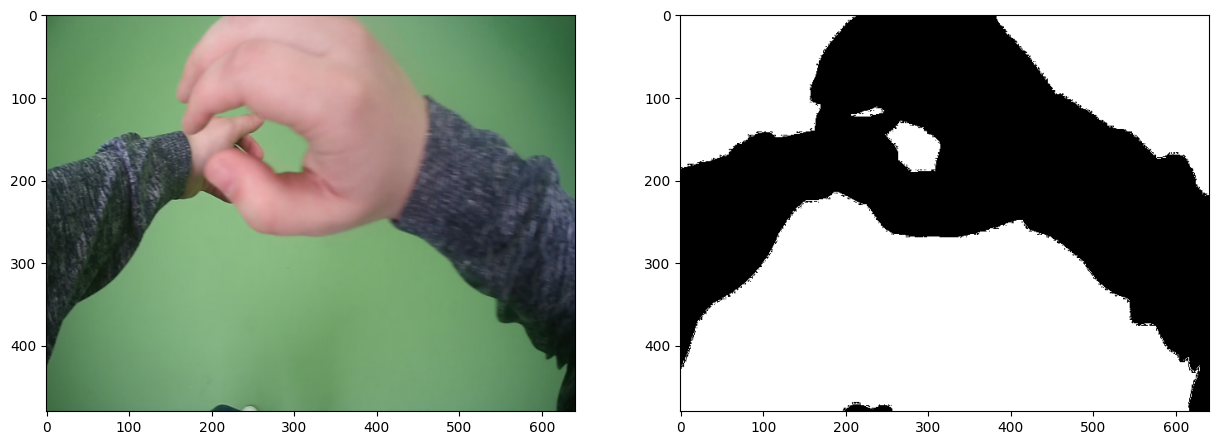

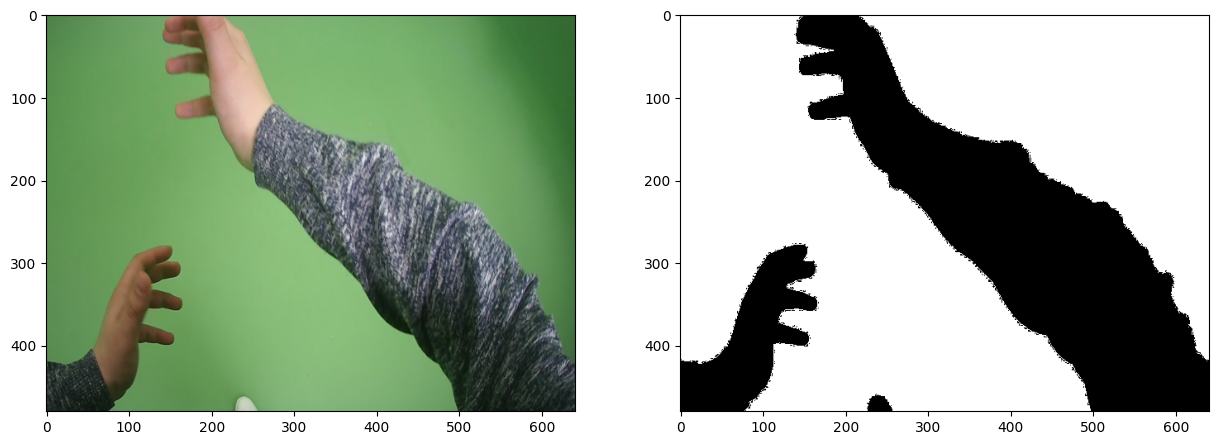

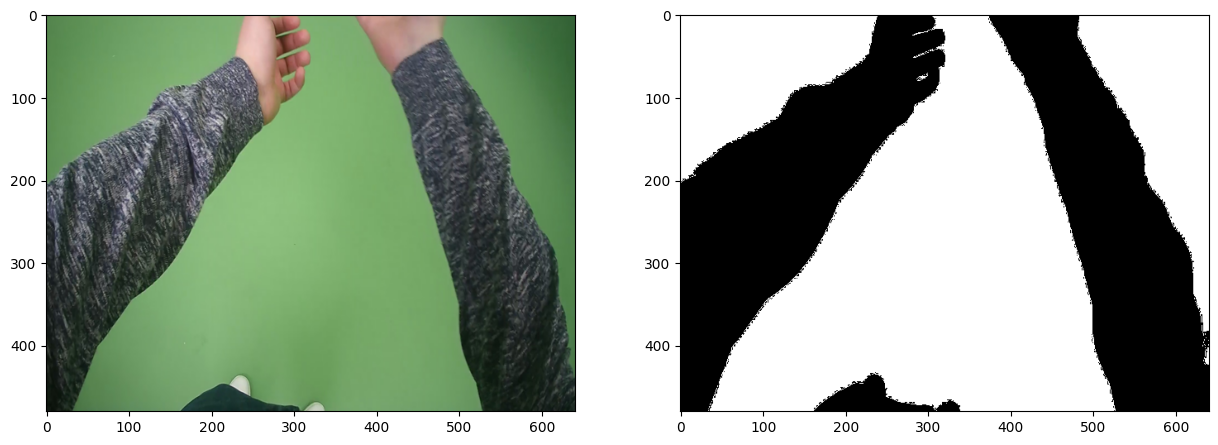

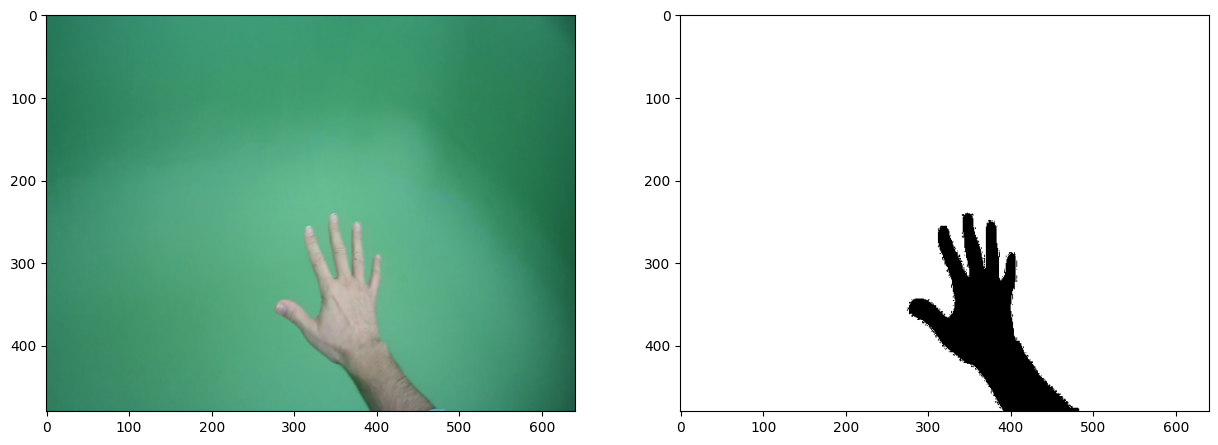

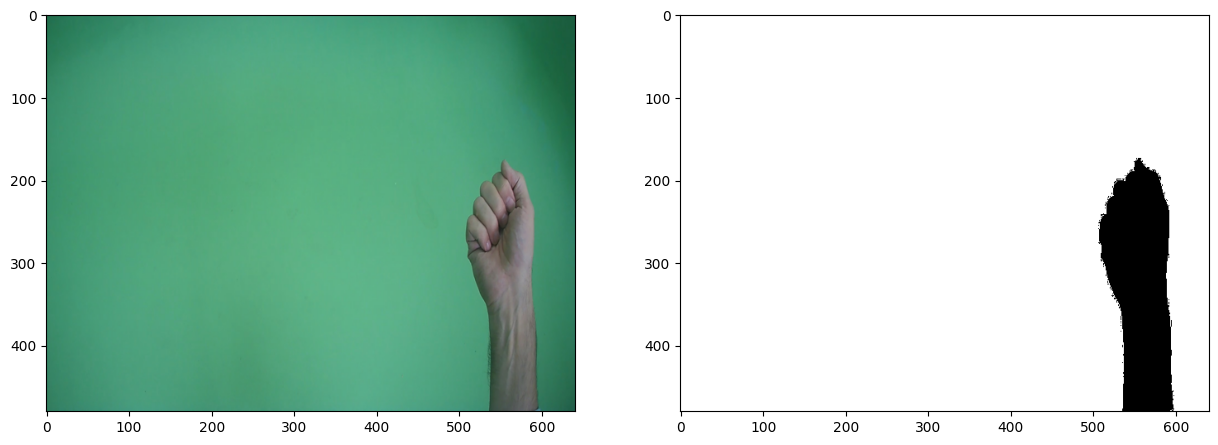

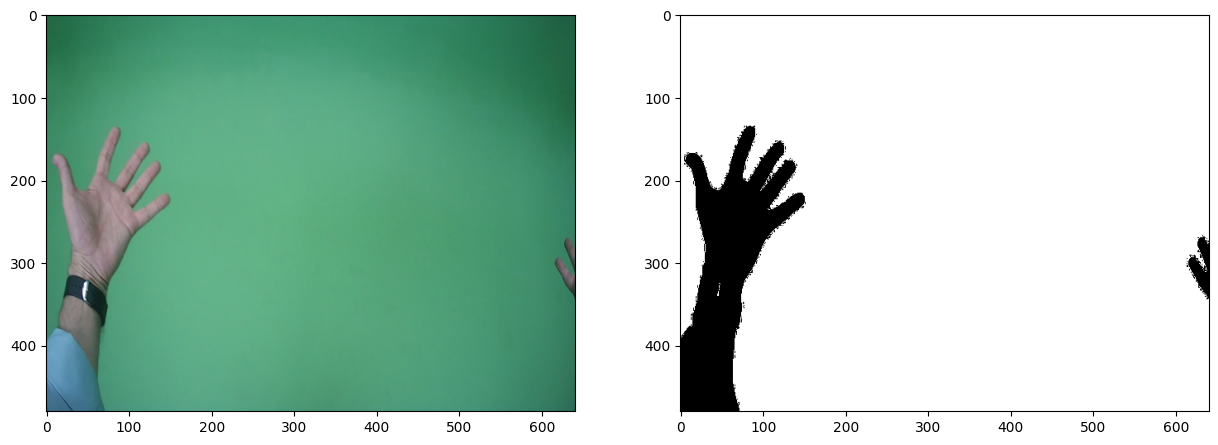

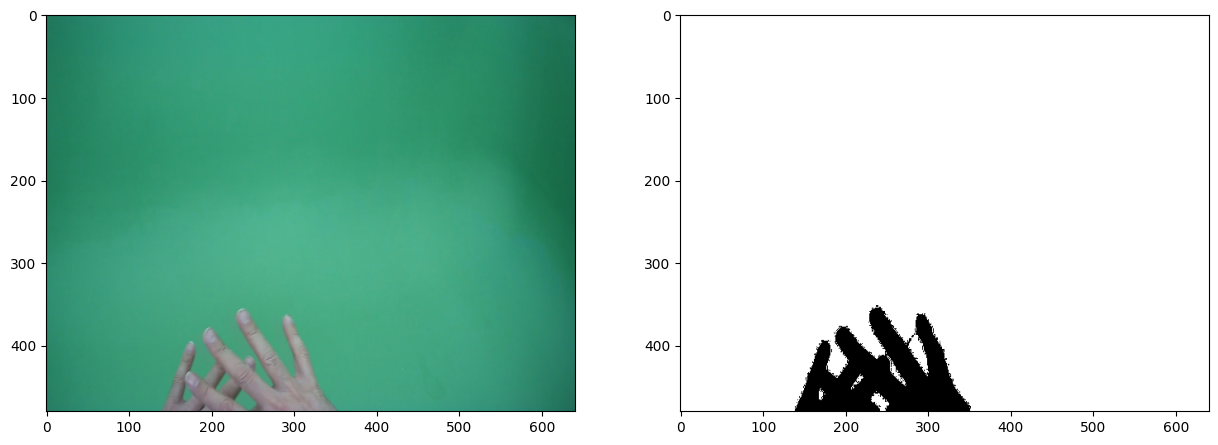

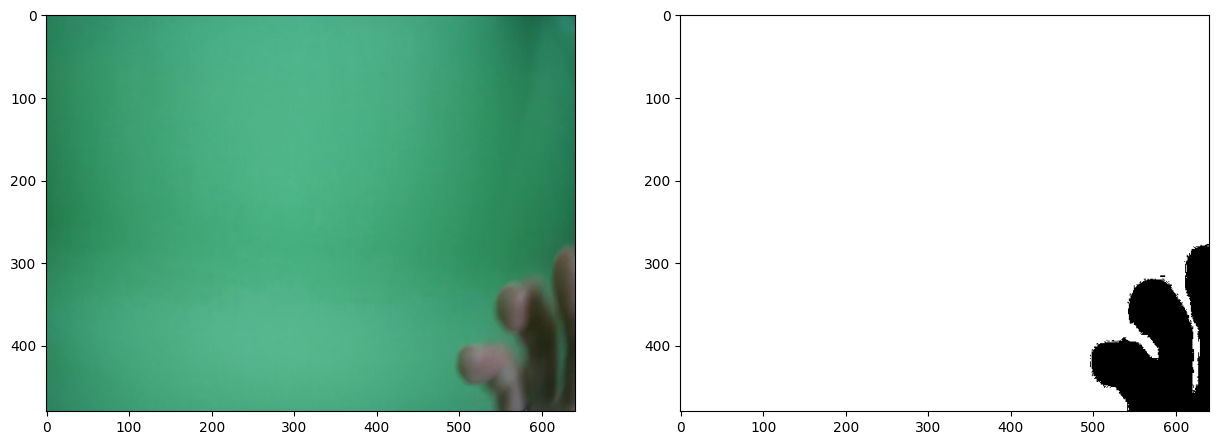

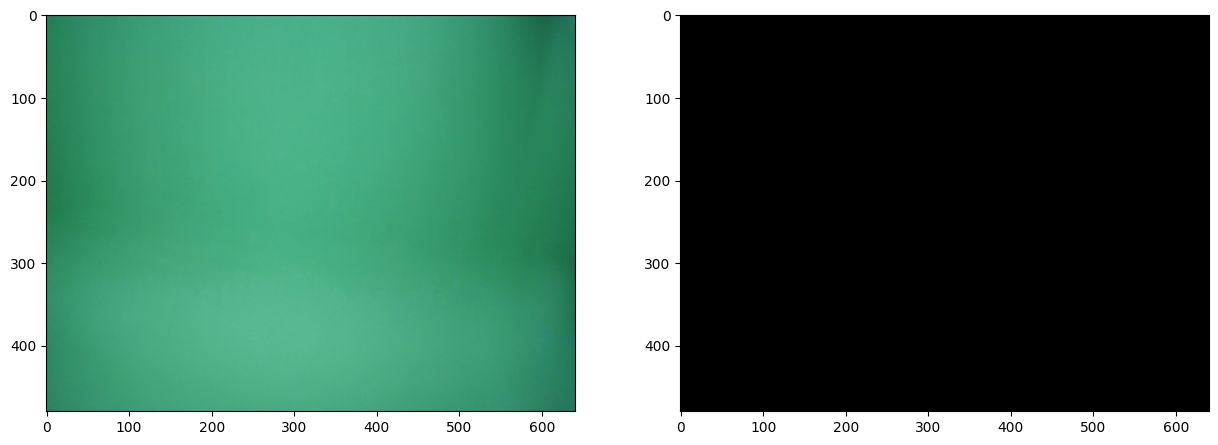

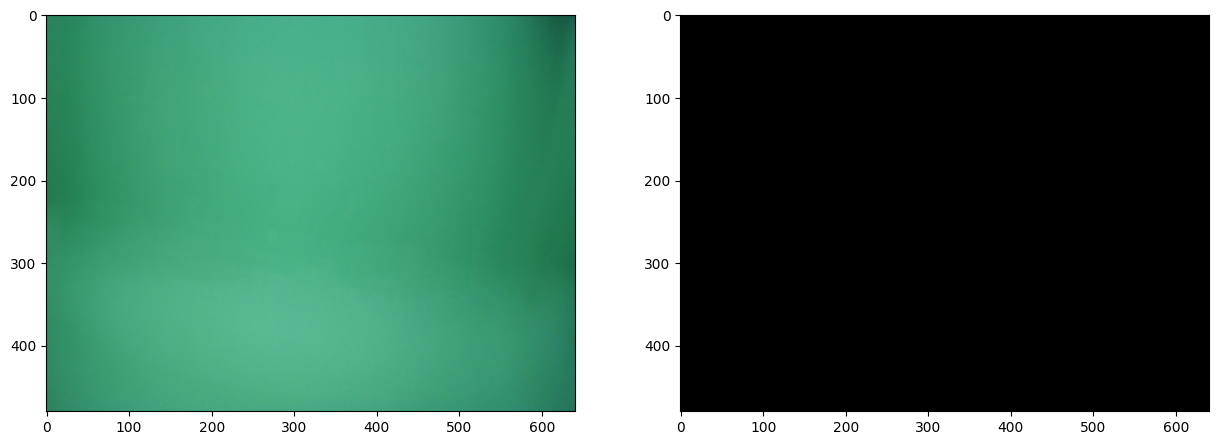

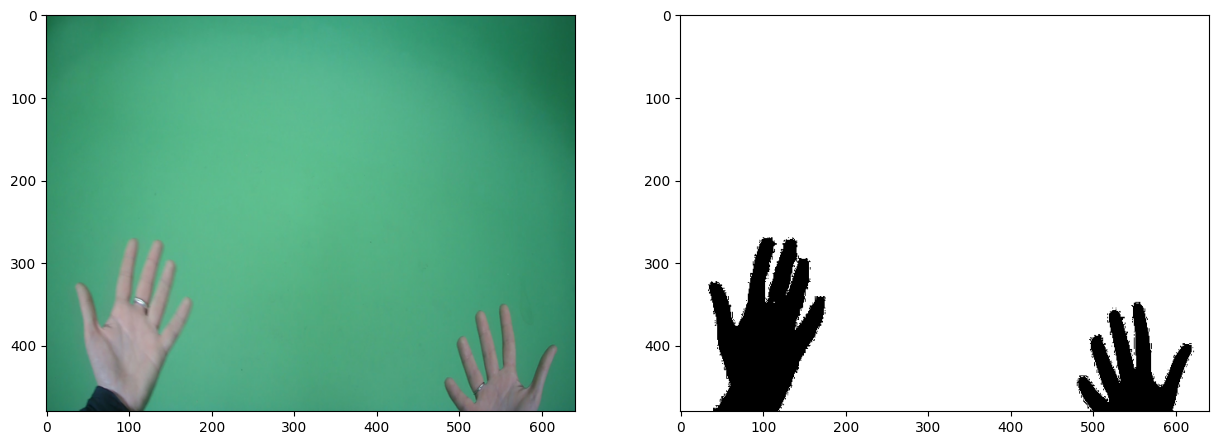

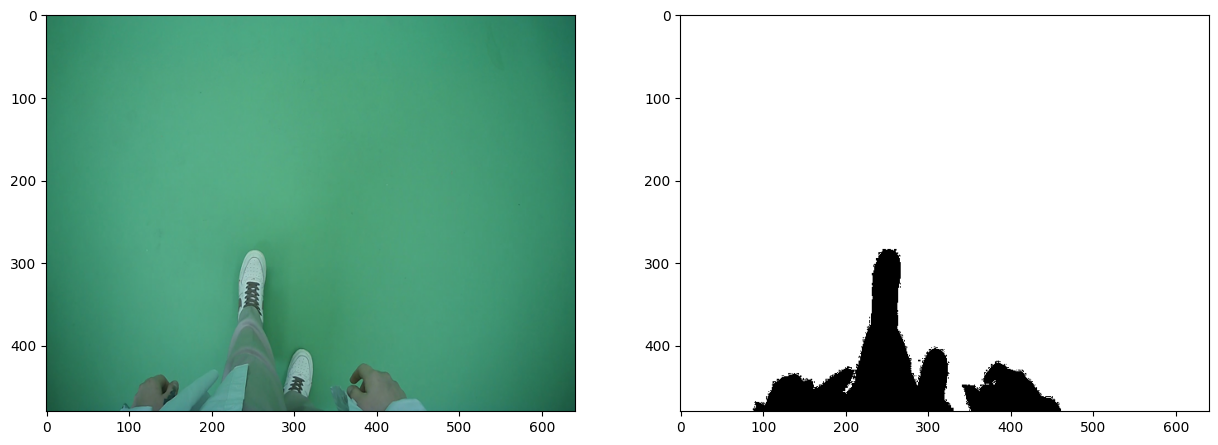

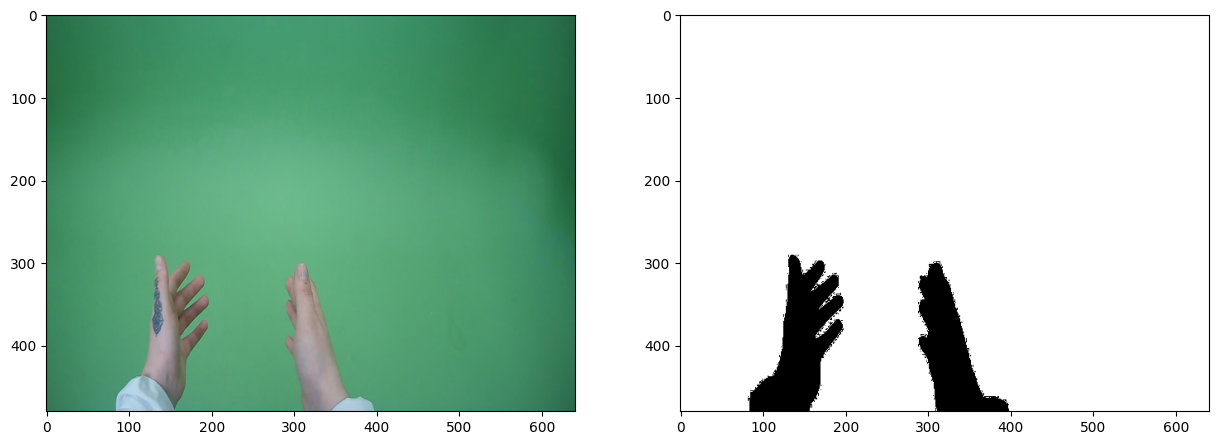

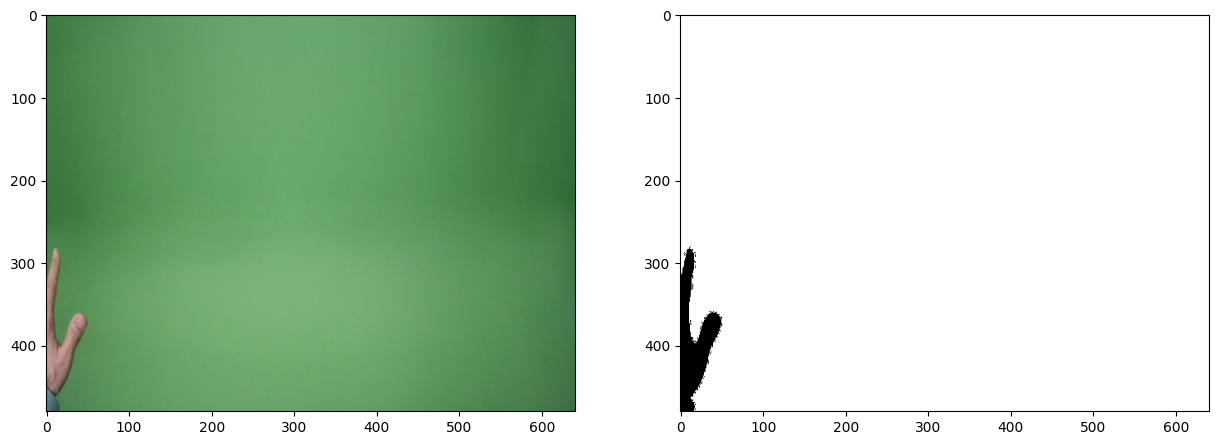

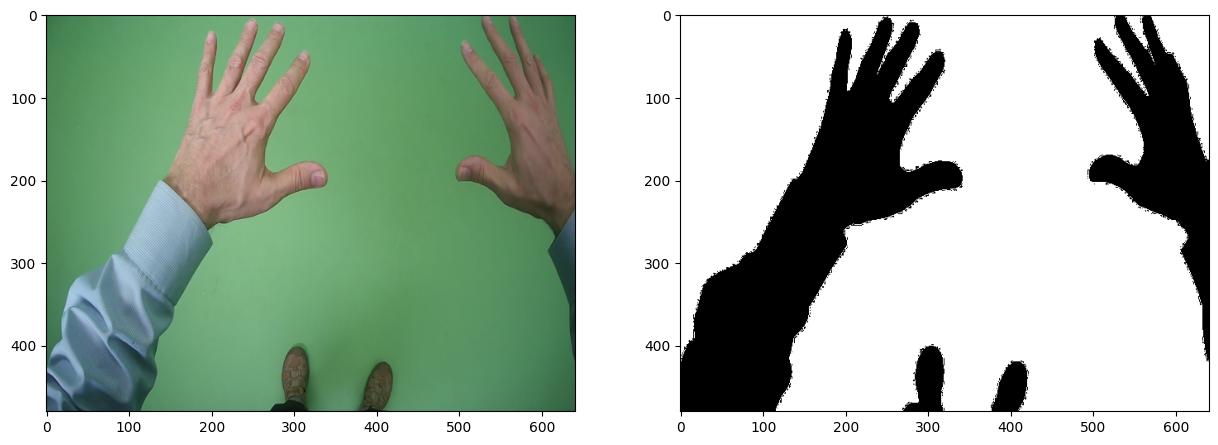

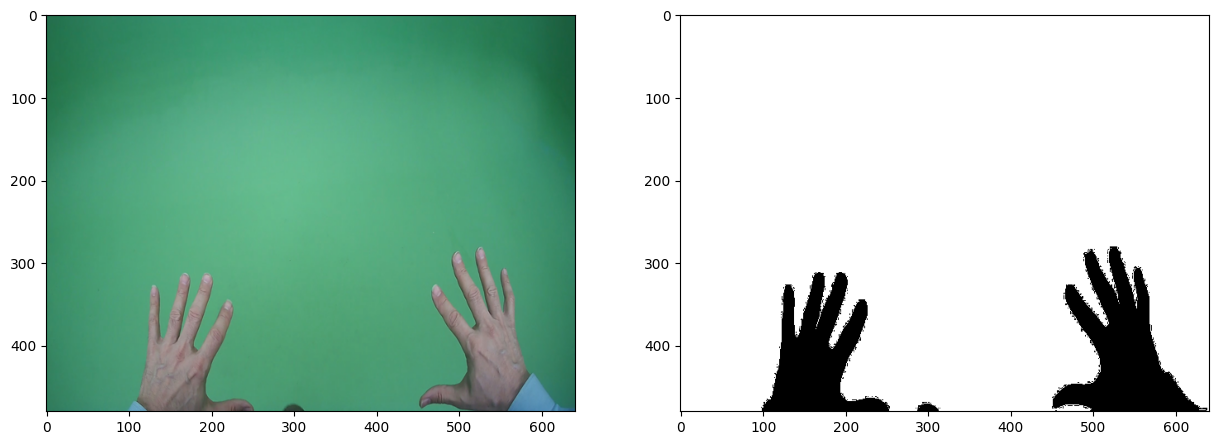

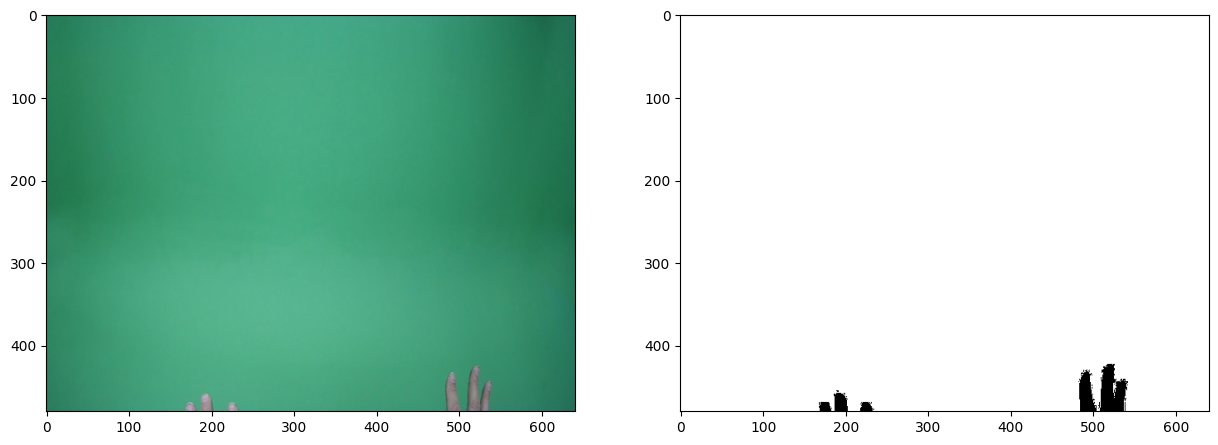

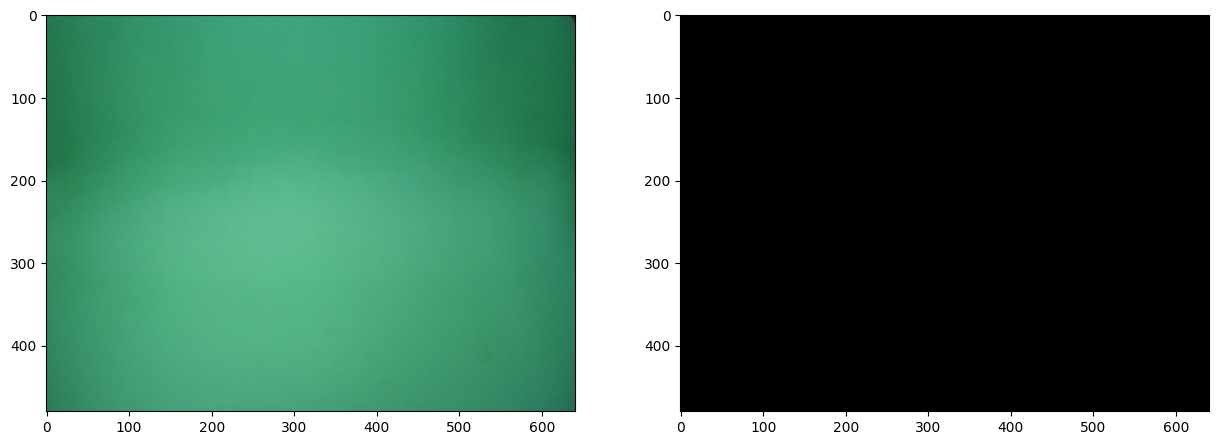

In [13]:
dim1 = 480
dim2 = 640
import matplotlib.pyplot as plt
for i in range(20):
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.imshow(X[i].reshape((dim1,dim2,3)))
    plt.subplot(1,2,2)
    plt.imshow(Y[i].reshape((dim1,dim2,1)), cmap='gray')
    plt.show()

In [13]:
X = np.load('data3000x7.npy')
Y = np.load('data3000y7.npy')
Y = swap_zeros_ones(Y)
Y = Y.astype(np.float64)

In [15]:
partsX = np.array_split(X, 2)
partsY = np.array_split(Y, 2)

In [8]:
# tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()

In [14]:
patience = 20
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights = True, min_delta=0.0001, patience = patience, verbose = 1)

In [ ]:
history = pspnet_model.fit(X, Y, epochs = 1000, validation_split = 0.2, batch_size = 4, callbacks=[early_stopping])

Epoch 1/1000
600/600 [==============================] - 114s 175ms/step - loss: 0.6166 - dice_coef: 0.3836 - val_loss: 0.6009 - val_dice_coef: 0.3991
Epoch 2/1000
600/600 [==============================] - 104s 174ms/step - loss: 0.5990 - dice_coef: 0.4010 - val_loss: 0.6056 - val_dice_coef: 0.3944
Epoch 3/1000
600/600 [==============================] - 105s 175ms/step - loss: 0.5996 - dice_coef: 0.4005 - val_loss: 0.6040 - val_dice_coef: 0.3960
Epoch 4/1000
600/600 [==============================] - 105s 176ms/step - loss: 0.5948 - dice_coef: 0.4053 - val_loss: 0.6042 - val_dice_coef: 0.3958
Epoch 5/1000
600/600 [==============================] - 106s 177ms/step - loss: 0.5831 - dice_coef: 0.4170 - val_loss: 0.6206 - val_dice_coef: 0.3794
Epoch 6/1000
600/600 [==============================] - 107s 178ms/step - loss: 0.5748 - dice_coef: 0.4253 - val_loss: 0.6812 - val_dice_coef: 0.3188
Epoch 7/1000
600/600 [==============================] - 106s 176ms/step - loss: 0.5698 - dice_coef: 

In [ ]:
pspnet_model.save('pspnet_X23')

In [5]:
pspnet_model = tf.keras.models.load_model('pspnet_X21.h5', custom_objects={'mish': mish, 'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

pspnet_model.compile( optimizer= 'adam', loss=dice_coef_loss, metrics=[dice_coef])